In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

In [2]:
#importing the dataset
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=150, resize=0.4)
#storing features in x
x = lfw_people.data
#storing classes in y
y = lfw_people.target
lfw_people.target_names

array(['Colin Powell', 'George W Bush'], dtype='<U13')

In [3]:
#number of samples (images) --> n_samples
#height and width of each image --> h,w
#height = 50 , width = 37  ==> each image consists of 50 x 37 = 1850 pixels 
nsamples, h, w = lfw_people.images.shape

# x consists of 766 images, each 1850 pixels
# ==> x : 766 rows and 1850 columns ==> x : (766 x 1850)
# ==> 766 samples (number of elements in x[0]) with 1850 features (number of elements in x[1])
nfeatures = x.shape[1]
#class is either 0 or 1, 0 representing 'Colin Powell' and 1 representing'George W Bush'
#it's handy to have an array such that array[0] = Colin Powell' and array[1] = 'George W Bush'
target_names = lfw_people.target_names
#we only have 2 classes (0 or 1; Powell or Bush --> the only 2 people satisfying the min_faces_per_person=150 constraint)
nclasses = target_names.shape[0]

print("Total dataset info:")
print("number of samples: %d" % nsamples)
print("number of features: %d" % nfeatures)
print("number of classes: %d" % nclasses)

Total dataset info:
number of samples: 766
number of features: 1850
number of classes: 2


In [4]:
#splitting data for training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
#we want to resize the distribution of values ==> the mean of the observed values-->0  and standard deviation-->1
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [5]:
print("Extracting the top %d eigenfaces from %d faces" % (100, x_train.shape[0]))
pca = PCA(n_components=100, svd_solver="randomized", whiten=True).fit(x_train)

eigenfaces = pca.components_.reshape((100, h, w))
#based off the graph, we can tell the number picked for n_components is suitable
#Projecting the input data on the eigenfaces orthonormal basis
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

Extracting the top 100 eigenfaces from 574 faces


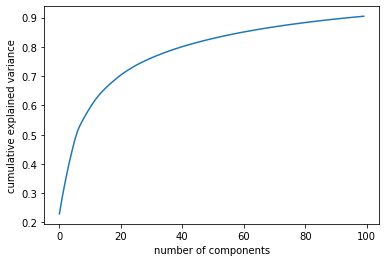

In [6]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

The plot shown above, helps us with choosing a suitable 'n_components' that capture a good amount (for instance 95%) of the variation

We want to Fit the classifier to the training set:

In [7]:
param_grid = {"C": loguniform(1e3, 1e5), "gamma": loguniform(1e-4, 1e-1)}
clf = RandomizedSearchCV(
SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10)
clf = clf.fit(x_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=2289.420615053246, class_weight='balanced', gamma=0.0025905975768713025)


Prediction on the test set:

               precision    recall  f1-score   support

 Colin Powell       0.98      0.90      0.94        59
George W Bush       0.96      0.99      0.97       133

     accuracy                           0.96       192
    macro avg       0.97      0.95      0.96       192
 weighted avg       0.96      0.96      0.96       192



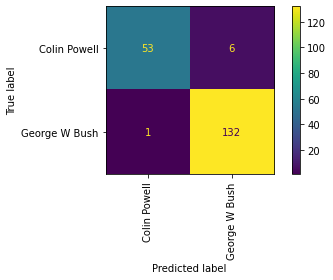

In [8]:
y_pred = clf.predict(x_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(clf, x_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical")
plt.tight_layout()
plt.show()

Functions to help with plotting images

In [9]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

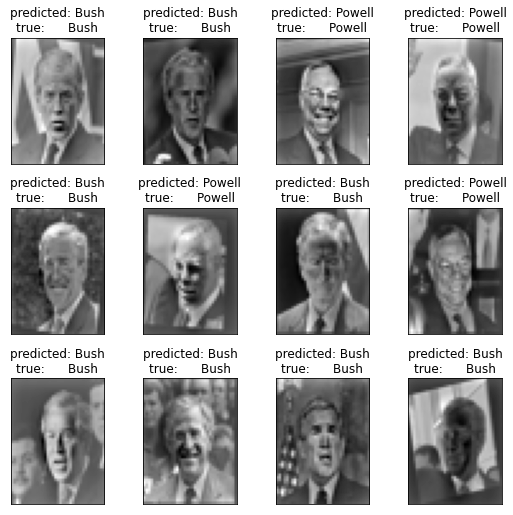

In [10]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(x_test, prediction_titles, h, w)

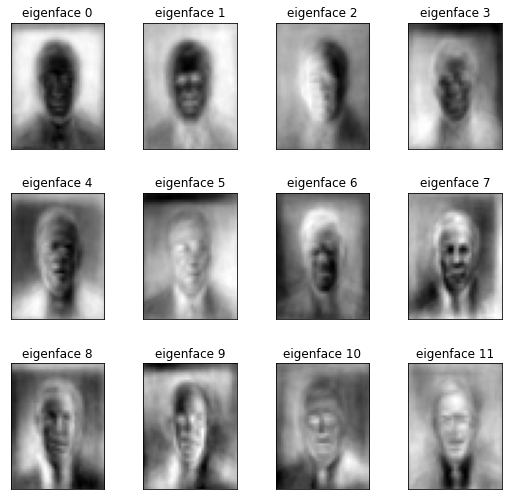

In [11]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

In [12]:
mlp = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
mlp.fit(x_train,y_train)

MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [13]:
pred=mlp.predict(x_test)
confusion_matrix(y_test,pred)

array([[ 53,   6],
       [  3, 130]])

In [14]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        59
           1       0.96      0.98      0.97       133

    accuracy                           0.95       192
   macro avg       0.95      0.94      0.94       192
weighted avg       0.95      0.95      0.95       192



Therefore, we've got accurate results with a lot lower dimensions